#### Project 4: Netflix NLP
#### Corey J Sinnott
# Modeling and Classification

## Executive Summary

This notebook contains model refinements.

## Contents:
- [Preprocessing & Feature Engineering](#Preprocessing-&-Feature-Engineering)
- [Classification](#Classification)
- [Evaluation](#Evaluation)
- [Conclusions & Recommendations](#Conclusions-&-Recommendations)

#### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, \
balanced_accuracy_score, precision_score, recall_score, roc_auc_score, \
plot_confusion_matrix, \
classification_report, plot_roc_curve, f1_score
from sklearn.compose import make_column_transformer, make_column_selector, ColumnTransformer
from sklearn import set_config
set_config(display = 'diagram')
from sklearn.inspection import permutation_importance
from category_encoders import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier

#### Reading-in Data

In [2]:
df_original = pd.read_csv('./data/netflix_titles.csv')

In [3]:
df = pd.read_csv('./data/netflix_prepped_df.csv')

In [4]:
# adding title as a column to vectorize
# df = df.set_index(keys = 'title')

In [5]:
df = df.dropna()

In [6]:
df = df.drop(columns = 'duration')

In [7]:
df.sample(1)

,title,type,country,rating,listed_in,description,description_length,description_word_count,descr_polarity,descr_subjectivity
7748,الف مبروك,Movie,Egypt,0.0,"Comedies, Dramas, International Movies","On his wedding day, an arrogant, greedy accoun...",151,26,0.0,0.125


In [8]:
df_to_merge = df.drop(columns = ['title', 'description'])

In [9]:
df['description_w_title'] = df['title'] + df['description']

In [10]:
df.description_w_title = df.description_w_title.str.replace('\d+', '')

# Preprocessing & Feature Engineering
 - Outside of pipeline to allow more time to fit models

 - CountVectorizing
     - Best parameters found:

In [11]:
cvzr = CountVectorizer(stop_words='english', max_features = 3000, 
                       ngram_range=(1, 1))

In [12]:
word_vect = cvzr.fit_transform(df['description_w_title'])

In [13]:

word_vect = pd.DataFrame(word_vect.toarray(), columns = cvzr.get_feature_names())

In [14]:
word_vect.shape

(7274, 3000)

 - OneHotEncoding text columns
     - Will experiment with not including
 - StandardScaling for numeric columns
     - Leaving off 'duration' until a standard can be found to compare movies with TV shows

In [15]:
ohe = OneHotEncoder()
ss = StandardScaler()

In [16]:
mct = make_column_transformer((ohe, ['listed_in', 'type', 'country']),
                              (ss, ['description_length','description_word_count',
                                    'descr_polarity','descr_subjectivity']),
                             remainder = 'drop')

In [17]:
df_to_merge = pd.DataFrame(mct.fit_transform(df_to_merge))

In [18]:
df_to_merge.shape

(7274, 1171)

In [19]:
#df_to_merge.info()

In [20]:
df_vect = pd.concat([df_to_merge.reset_index(), word_vect], axis = 1)

In [21]:
df_vect.shape

(7274, 4172)

In [22]:
df_vect.drop(columns = 'index', inplace = True)

In [23]:
df_vect.shape

(7274, 4171)

#### Defining Variables

In [24]:
X = df_vect
y = df['rating']

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

# Classification
 - Including all features in testing

#### Null Model

In [26]:
print(round(y_train.mean(), 2))
print(round(1 - y_train.mean(), 2))

0.47
0.53


In [27]:
def classification_eval(y_test, y_pred):
    print(f'accuracy  = {np.round(accuracy_score(y_test, y_pred), 3)}')
    print(f'precision = {np.round(precision_score(y_test, y_pred), 3)}')
    print(f'recall    = {np.round(recall_score(y_test, y_pred), 3)}')
    print(f'f1-score  = {np.round(f1_score(y_test, y_pred), 3)}')
    print(f'roc auc score  = {np.round(roc_auc_score(y_test, y_pred), 3)}')

#### Random Forest Classifier
  - Best accuracy score = 
  - n_grams = 
  - max_feat = 
  - StandardScaler for numeric columns
  - OneHotEncoding for text  columns
  - parameters as noted below
  - includes all features
      - many combination of features were tested
  - attempted many variations not represented below, including:
       - tuning of n_grams and max features
       - different vectorizing and tokenizing tools

In [36]:
from t

In [31]:
rf = RandomForestClassifier()

In [32]:
pipe = make_pipeline(rf)

In [33]:
params = {
    'n_estimators' : [1000, 2500],
    'ccp_alpha' : [0.0, 0.01, 0.001],
    'min_samples_leaf' : [0, 1, 3],
    'criterion' : ['gini', 'entropy'],
    'oob_score' : [True, False]
}

In [34]:
params_short = {
    'randomforestclassifier__n_estimators' : [1000],
    'randomforestclassifier__ccp_alpha' : [0.0],
    'randomforestclassifier__min_samples_leaf' : [1, 3],
    'randomforestclassifier__criterion' : ['entropy'],
    'randomforestclassifier__oob_score' : [False]
}

In [35]:
grid = GridSearchCV(pipe, params_short, n_jobs = -1)

In [117]:
grid.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('randomforestclassifier',
                                        RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__ccp_alpha': [0.0],
                         'randomforestclassifier__criterion': ['entropy'],
                         'randomforestclassifier__min_samples_leaf': [1, 3],
                         'randomforestclassifier__n_estimators': [1000],
                         'randomforestclassifier__oob_score': [False]})

In [118]:
y_pred = grid.predict(X_test)

classification_eval(y_test, y_pred)

accuracy  = 0.726
precision = 0.723
recall    = 0.642
f1-score  = 0.68
roc auc score  = 0.719


In [119]:
print(f'Null model accuracy: {round(max(y_test.mean(), 1 - y_test.mean()), 2)}')

Null model accuracy: 0.55


# Evaluation

In [120]:
grid.best_params_

{'randomforestclassifier__ccp_alpha': 0.0,
 'randomforestclassifier__criterion': 'entropy',
 'randomforestclassifier__min_samples_leaf': 3,
 'randomforestclassifier__n_estimators': 1000,
 'randomforestclassifier__oob_score': False}

In [121]:
y_pred_prob = grid.predict_proba(X_test)

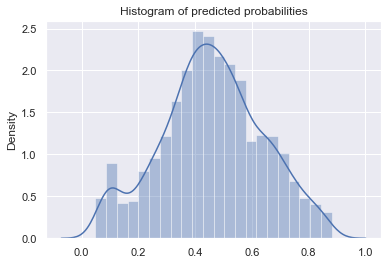

In [122]:
sns.set(style="darkgrid", context="notebook")
sns.distplot(y_pred_prob[:, 1]);
plt.title('Histogram of predicted probabilities');

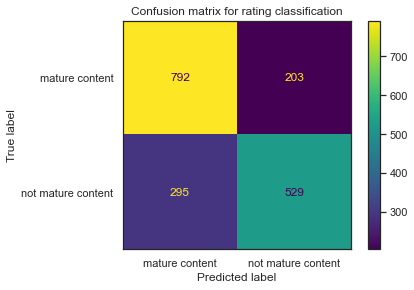

In [123]:
sns.set(style="white", context="notebook")
plot_confusion_matrix(grid, X_test, y_test, 
                      display_labels = ['mature content', 
                                        'not mature content']);
plt.tight_layout();
plt.title('Confusion matrix for rating classification');

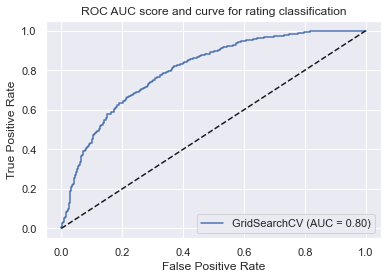

In [124]:
sns.set(style="darkgrid", context="notebook")
plot_roc_curve(grid, X_test, y_test)
plt.title('ROC AUC score and curve for rating classification');
plt.plot([0,1], [0,1], 'k--')
plt.show();

In [125]:
feats = grid.best_estimator_.named_steps['randomforestclassifier']

In [126]:
feat_names = [i for i in X_train]

In [127]:
rating = [i for i in y_train]

In [128]:
feat_import_df = pd.DataFrame({'importances': feats.feature_importances_, 
 'name': feat_names}).sort_values('importances')

In [129]:
feat_import_df.sort_values('importances', ascending = False).head(15)

,importances,name
492,0.033581,492
61,0.031244,61
97,0.028763,97
59,0.027834,59
73,0.021398,73
1169,0.015659,1169
137,0.013246,137
504,0.011867,504
1167,0.009565,1167
1170,0.009533,1170


In [130]:
words = [i for i in feat_import_df['name']]

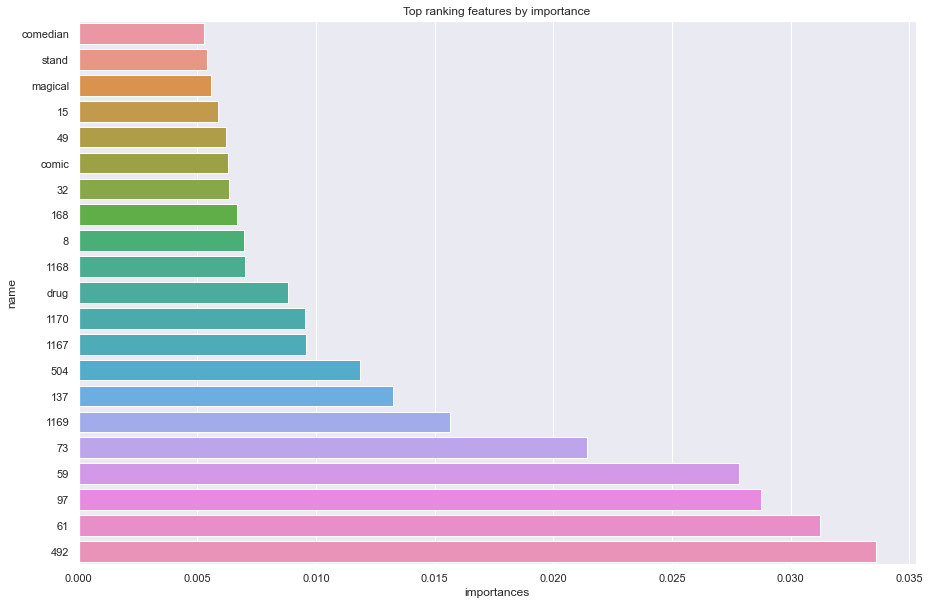

In [131]:
sns.set(style="darkgrid", context="notebook")
plt.figure(figsize=(15, 10))
x = feat_import_df['importances'].tail(21)
y = feat_import_df['name'].tail(21)
sns.barplot(x = x, y = y).set_title('Top ranking features by importance');

# Conclusion and Recommendations

 - Based on the findings, we can determine if a Netflix program will have adult content by ~20% greater than a null model. The key limitation in obtaining greater accuracy was a lack of defining key words, and perhaps some overlap between TV-14 and TV-MA ratings, as well as PG-13 ratings. Furthermore, with more time, the model can be further refined and more word vectorization techniques can be explored.
 
 - In conclusion, it is recommended that more time is put toward refining and tuning the model using GridSearchCV parameters, and that other word vectorization techniques are explored, such as increading max features, and including bi and tri-grams.

Corey J Sinnott
Project 4, Netflix NLP